In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import pairwise_distances_argmin, silhouette_score
from sklearn.decomposition import PCA

In [201]:
# note that the data is already scaled from '01_preprocessing.ipynb"
data = pd.read_csv("../../data/processed/spotify_features.csv")

X = data
print(f"The shape of the data set is: {X.shape}")
X.head()

The shape of the data set is: (1159748, 13)


,track_name,artist_name,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,loudness,duration_sec,popularity
0,I Won't Give Up,Jason Mraz,-0.295121,-1.244639,-1.178954,1.049226,-0.691216,-0.537222,-0.393524,0.403917,-0.189488,-0.062859,3.123384
1,93 Million Miles,Jason Mraz,0.187328,-0.686411,0.221331,0.437937,-0.691179,-0.624753,-0.528338,0.631455,-0.229613,-0.221997,1.990284
2,Do Not Let Me Go,Joshua Hyslop,-0.696259,-1.499723,-1.156609,0.046373,-0.691079,-0.664042,-0.477093,0.619702,-0.832373,-0.606319,2.430934
3,Fast Car,Boyce Avenue,-0.788412,-1.436876,0.195262,1.367548,-0.691216,-0.712781,-0.445557,2.806734,-0.152002,0.366301,2.493884
4,Sky's Still Blue,Andrew Belle,-0.582422,0.559434,-0.888469,-0.701259,-0.638350,-0.562088,-0.493649,1.695337,0.626921,-0.035059,2.242084


# Train Test Split

In [202]:
RANDOM_STATE = 42
categorical_data = ['artist_name', 'track_name']
X = X.drop(columns=categorical_data + ["duration_sec"], axis=1)

X_train, X_test = train_test_split(X, test_size= 0.05, random_state=RANDOM_STATE)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1101760, 10)
X_test shape: (57988, 10)


### PreProcessing (PCA)

In [203]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# print(f"X_train_reduced shape: {X_train_reduced.shape}")
# print(f"X_test_reduced shape: {X_test_reduced.shape}")

variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratios)

print("~~~~~Cumulative variance at n components~~~~~~")
for i, cum_ratio in enumerate(cumulative_variance):
    print(f"Component {i+1}: {cum_ratio * 100:.2f}%")

print(f"\nVariance target reached at {len(cumulative_variance)} components: {cumulative_variance[-1] * 100:.2f}%")

~~~~~Cumulative variance at n components~~~~~~
Component 1: 29.24%
Component 2: 43.87%
Component 3: 57.38%
Component 4: 67.89%
Component 5: 76.60%
Component 6: 84.71%
Component 7: 91.41%
Component 8: 95.64%

Variance target reached at 8 components: 95.64%


In [204]:
batch_size = 100
n_clusters = 1000

print(f"Batch size: {batch_size}")
print(f"n_clusters: {n_clusters}")
start_time = time.perf_counter()
mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=n_clusters,
    batch_size=batch_size,
    n_init=50,
    random_state=RANDOM_STATE
)

mbk.fit(X_train_reduced)
print("model has been fit")

end_time = time.perf_counter()

mbk_means_clusters_centers = np.sort(mbk.cluster_centers_, axis=0)
mbk_means_labels = pairwise_distances_argmin(X_test_reduced, mbk_means_clusters_centers)
elapsed_time = end_time - start_time

# score_start = time.perf_counter()
# score = silhouette_score(X_train_reduced, mbk.labels_)
# score_end = time.perf_counter()
# score_time = score_end - score_start
# print(f"Silhouette Score: {score}")
# print(f"Score time: {score_time:.4f}")

print(f"Execution time: {elapsed_time:.4f} seconds")
print(mbk_means_labels)

Batch size: 100
n_clusters: 1000
model has been fit
Execution time: 6.5324 seconds
[ 99 571 501 ... 365 497 159]


# Visualize K-Means

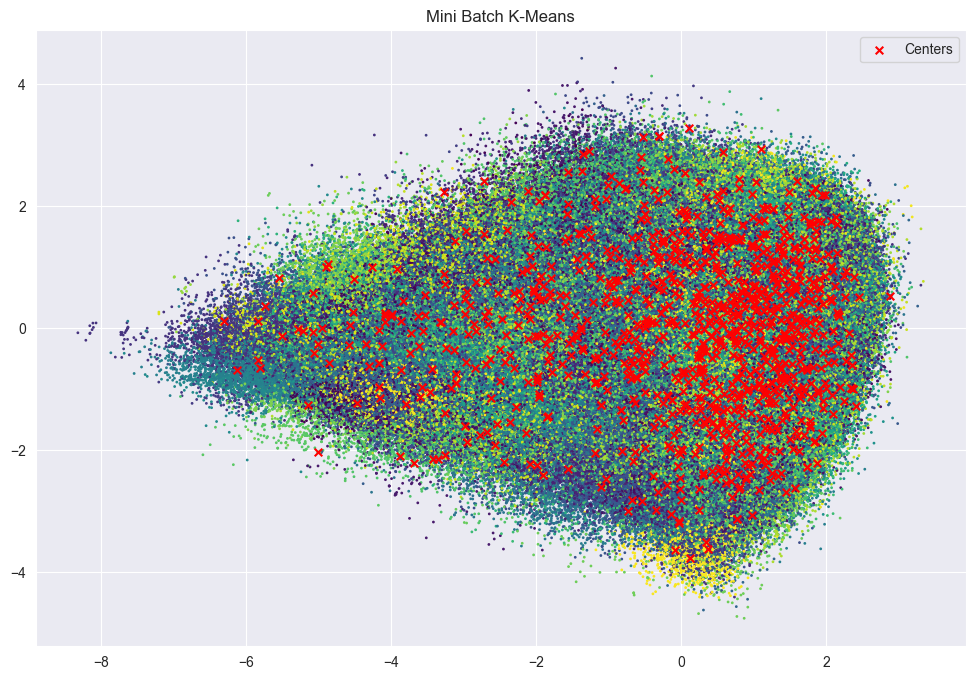

In [205]:
pca_visual = PCA(n_components= 2)
X_train_visual = pca_visual.fit_transform(X_train_reduced)

centers = mbk.cluster_centers_
labels = mbk.labels_

plt.figure(figsize=(12, 8))
plt.scatter(X_train_visual[:, 0], X_train_visual[:, 1], c=labels, cmap="viridis", s=1)
plt.scatter(centers[:, 0], centers[:, 1], marker="x", color="red", label="Centers", s=30)
plt.title("Mini Batch K-Means")
plt.grid(True)
plt.legend()
plt.show()

Predict

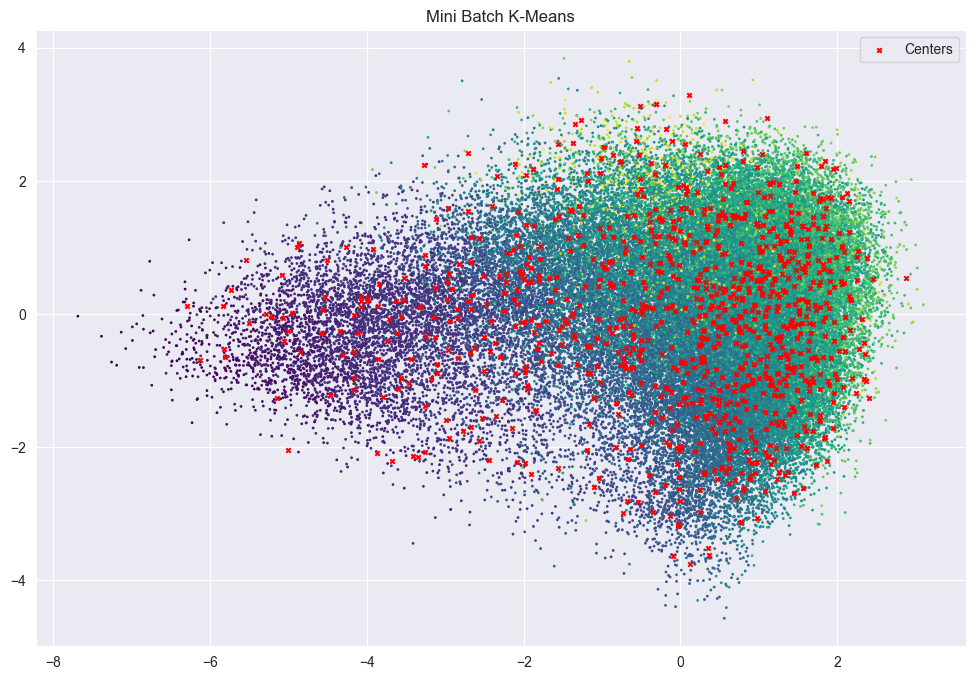

In [206]:
mbk.predict(X_test_reduced)

labels = mbk_means_labels
centroids = mbk.cluster_centers_

X_test_visual = pca_visual.transform(X_test_reduced)

plt.figure(figsize=(12, 8))
plt.scatter(X_test_visual[:, 0], X_test_visual[:, 1], c=labels, cmap="viridis", s=1)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", color="red", label="Centers", s=10)
plt.title("Mini Batch K-Means")
plt.grid(True)
plt.legend()
plt.show()


# Evaluate